Import Necessary Packages

In [1]:
import cluster_freq
import generate_clusters
import generate_plotly
import get_matches
import json
import matplotlib.pyplot as plt
import networkx as nx
import network_graph
import numpy as np
import pandas as pd
import plotly 
import plotly.plotly as py
from plotly.graph_objs import *
import pylab
import set_plotly_credentials as setply
from sklearn.cluster import KMeans

Read in Dataset

In [2]:
filepath = 'https://raw.githubusercontent.com/rmw647/not-that-into-you/master/Speed%20Dating%20Data.csv'
data = pd.read_csv(filepath, encoding='latin1')

Downselect columns to ones needed for analysis and create a smaller dataframe with only those columns.

In [3]:
keep_columns = ['iid','pid','match','age','sports','tvsports','exercise','dining','museums',
                'art','hiking','gaming','clubbing','reading','tv','theater','movies','concerts',
                'music','shopping','yoga','exphappy']
bio_info = data[keep_columns]
bio_info = bio_info.dropna(how='any')

Original dataframe has 10 records for each participant (one record for each date they went on). Create a subsetted dataframe that contains only one row for participant.

In [4]:
bio_info_subset = bio_info.drop_duplicates(subset='iid')

Select out the data for particpants who matched. Create a dataframe of patching pairs and a list of edges with data (person1,  person2).

In [5]:
matches, edges = get_matches.get_matches(bio_info)

Perform K-means clustering. No need to normalize because all data used is on the same scale (1- 10). We ran for several different numbers of clusters, and found 3 was a manageable number that still offered granularity.

Add a column to the subsetted data that shows the cluster assignment for each participant.

In [18]:
cluster_columns = ['sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing',
                   'reading','tv','theater','movies','concerts','music','shopping','yoga','exphappy']
number_of_clusters = 4
bio_info_subset = generate_clusters.generate_clusters(bio_info_subset, cluster_columns, 
                                                      number_of_clusters,'cluster_assignment')

/Users/rebeccaward/uw_class/not-that-into-you/generate_clusters.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Create and plot a network graph showing the interactions within and between clusters of people.

In [19]:
G, clusters = network_graph.network_graph(bio_info_subset, edges, "circles", number_of_clusters)

In [20]:
setply.set_plotly_credentials('credentials.json')

In [ ]:
awesome_plot = generate_plotly.generate_plotly(G, clusters)

In [13]:
awesome_plot

Do people within the same cluster match with each other more frequently than they match with people in other clusters? Make a plot showing how often people match within cluster and outside cluster.

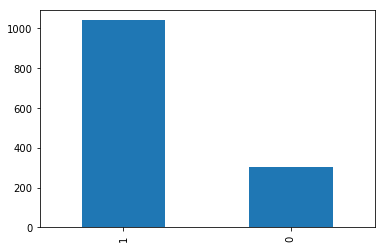

In [21]:
cluster_freq.cluster_freq(clusters,matches)

In [22]:
cluster_sizes = cluster_freq.get_cluster_size(bio_info_subset)
cluster_sizes

{'cluster0': 115, 'cluster1': 158, 'cluster2': 132, 'cluster3': 137}

In [23]:
profiles = bio_info_subset.groupby(['cluster_assignment']).mean()
profiles.drop(['pid','iid'], inplace=True,axis=1)

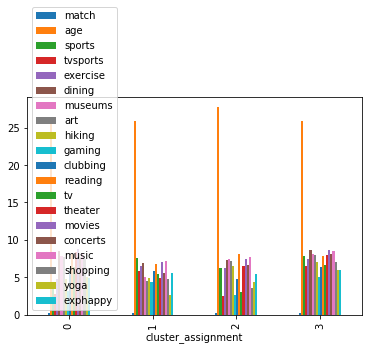

In [24]:
%matplotlib inline
profiles.plot(kind = 'bar')